# Qualche esempio di uso dei transformer per il NLP

Luca Mari, gennaio 2025  

Quest'opera è distribuita con <a href="http://creativecommons.org/licenses/by-nc-sa/4.0" target="_blank">Licenza Creative Commons Attribuzione - Non commerciale - Condividi allo stesso modo 4.0 Internazionale</a>.  
<img src="https://creativecommons.it/chapterIT/wp-content/uploads/2021/01/by-nc-sa.eu_.png" width="100">

**Obiettivo**: essere informati di alcune possibili modalità di uso "di alto livello" dei trasformer per applicazioni con testi in lingua italiana e della libreria Python `transformers` di Hugging Face.  
**Precompetenze**: basi di Python.

> Per eseguire questo notebook con VSCode sul proprio calcolatore, occorre:
> * installare un interprete Python
> * scaricare da https://code.visualstudio.com/download e installare VSCode
> * eseguire VSCode e attivare le estensioni per Python e Jupyter
> * ancora in VSCode:
>     * creare una cartella di lavoro e renderla la cartella corrente
>     * copiare nella cartella il file di questa attività: [transformerapps.ipynb](transformerapps.ipynb)
>     * aprire il notebook `transformerapps.ipynb`
>     * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
>     * installare i moduli Python richiesti, eseguendo dal terminale:  
>         `pip install transformers torch sentencepiece protobuf`

**Indice**  
[1. Part-of-Speech (POS) tagging](#s1)  
[2. Sentiment analysis](#s2)  
[3. Zero-shot classification](#s3)  
[4. Named Entity Recognition (NER)](#s4)  
[5. Fill mask](#s5)  
[6. Question answering](#s6)  
[7. Text generation (completamento)](#s7)  
[8. Translation](#s8)  
[9. Text generation (Q&A)](#s9)

Sappiamo che con sistemi come `ChatGPT` possiamo dialogare liberamente e in molte lingue. Grazie al modulo Python `transformers` di Hugging Face (https://huggingface.co/docs/transformers) e ai tanti modelli accessibili e scaricabili liberamente da Hugging Face stesso, con poche linee di codice Python è possibile costruire applicazioni con funzionalità specifiche, anche in grado di trattare testi in lingua italiana con una qualità spesso accettabile.

I modelli in questione sono spesso di dimensioni relativamente piccole, e perciò possono essere eseguiti in locale. Anche se condividono la stessa architettura di base -- perché sono tutti transformer --, sono tipicamente addestrati per applicazioni specifiche.

Nel seguito mostriamo alcuni esempi, per ognuno dei quali usiamo un modello appropriato.

Per prima cosa importiamo i moduli Python che useremo e specifichiamo che, per semplicità, faremo eseguire il codice sempre in CPU anche nel caso una GPU sia disponibile.

In [1]:
from transformers import pipeline, AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import textwrap
from IPython.display import Markdown, display
import logging
from transformers import logging as transformers_logging

logging.basicConfig(level=logging.ERROR)
transformers_logging.set_verbosity_error()

device = "cpu"

def info(model):
    print('Modello con:')
    tokenizer = AutoTokenizer.from_pretrained(model)
    print(f'-- un vocabolario di {tokenizer.vocab_size} token')
    x = tokenizer.model_max_length
    print(f'-- un contesto di {x} token') if x < 1e12 else print('-- un contesto di lunghezza non definita')
    transformer = AutoModel.from_pretrained(model)
    model_parameters = filter(lambda p: p.requires_grad, transformer.parameters())
    y = sum([np.prod(p.size()) for p in model_parameters])
    z = f"{(y / 1e9):.2f}B" if y > 1e9 else f"{int(y / 1e6)}M"
    print(f'-- {z} parametri\n')

def wprint(text, width=120):
    print(textwrap.fill(text, width=width))

def printmd(string):
    display(Markdown(string))

<a id="s1"></a>
### 1. Part-of-Speech (POS) tagging
(modello https://huggingface.co/sachaarbonel/bert-italian-cased-finetuned-pos)

In [2]:
model = "sachaarbonel/bert-italian-cased-finetuned-pos"
info(model)
pos = pipeline("token-classification", model=model, device=device)
sentence = "Abbiamo partecipato a una lezione interessante."
res = pos(sentence)

if res is not None:
    print(f'Frase da analizzare:\n"{sentence}"')
    print('\nParti del discorso individuate:')
    for part in res:
        print(part)

Modello con:
-- un vocabolario di 31102 token
-- un contesto di 512 token
-- 109M parametri

Frase da analizzare:
"Abbiamo partecipato a una lezione interessante."

Parti del discorso individuate:
{'entity': 'AUX', 'score': 0.9989906, 'index': 1, 'word': 'abbiamo', 'start': 0, 'end': 7}
{'entity': 'VERB', 'score': 0.99978894, 'index': 2, 'word': 'partecipato', 'start': 8, 'end': 19}
{'entity': 'ADP', 'score': 0.99955493, 'index': 3, 'word': 'a', 'start': 20, 'end': 21}
{'entity': 'DET', 'score': 0.99955136, 'index': 4, 'word': 'una', 'start': 22, 'end': 25}
{'entity': 'NOUN', 'score': 0.9997603, 'index': 5, 'word': 'lezione', 'start': 26, 'end': 33}
{'entity': 'ADJ', 'score': 0.99962294, 'index': 6, 'word': 'interessante', 'start': 34, 'end': 46}
{'entity': 'PUNCT', 'score': 0.9856426, 'index': 7, 'word': '.', 'start': 46, 'end': 47}


<a id="s2"></a>
### 2. Sentiment analysis
(modello https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)

Modello con:
-- un vocabolario di 105879 token
-- un contesto di 512 token
-- 167M parametri

Frase da analizzare:
"Questa lezione è stata chiara ma non così interessante"

Valutazione:
[{'label': '1 star', 'score': 0.04},
 {'label': '2 stars', 'score': 0.22},
 {'label': '3 stars', 'score': 0.61},
 {'label': '4 stars', 'score': 0.11},
 {'label': '5 stars', 'score': 0.01}]


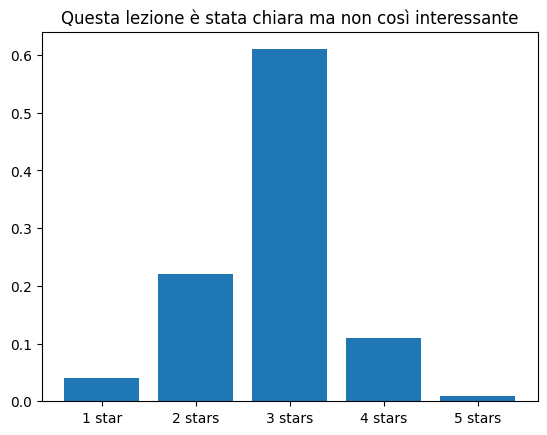

In [3]:
model = 'nlptown/bert-base-multilingual-uncased-sentiment'
info(model)
classifier = pipeline("sentiment-analysis", model=model, device=device)
sentence = "Ho trovato molto attraente questa lezione"
res = classifier(sentence, top_k=None)

if res:
    print(f'Frase da analizzare:\n"{sentence}"')
    print('\nValutazione:')
    res = sorted(res, key=lambda x: x['label']) # type: ignore
    pprint(res)

    labels = [r['label'] for r in res]
    scores = [r['score'] for r in res]
    plt.bar(labels, scores)
    plt.title(sentence)
    plt.show()

<a id="s3"></a>
### 3. Zero-shot classification
(modello https://huggingface.co/Jiva/xlm-roberta-large-it-mnli)

Modello con:
-- un vocabolario di 250002 token
-- un contesto di 512 token
-- 559M parametri

Frase da analizzare:
"In questa lezione abbiamo parlato di Alan Turing"

Categorie:
"['economia', 'geografia', 'politica', 'sport', 'storia', 'tecnologia']"

Classificazione:
[('tecnologia', 0.39),
 ('storia', 0.23),
 ('geografia', 0.11),
 ('politica', 0.1),
 ('economia', 0.08),
 ('sport', 0.08)]


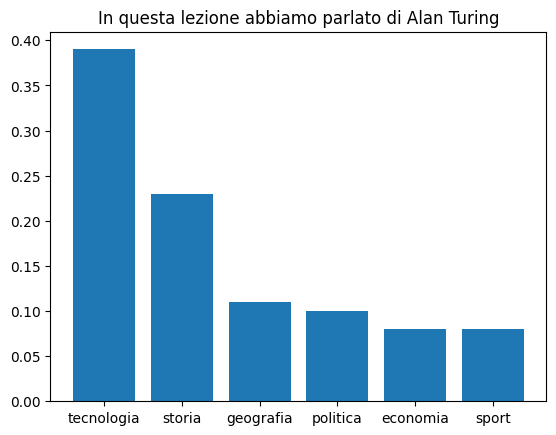

In [4]:
model = 'Jiva/xlm-roberta-large-it-mnli'
info(model)
classifier = pipeline("zero-shot-classification", model=model, device=device)
sentence = "In questa lezione abbiamo presentato l'orografia del territorio italiano"
candidate_labels = ["economia", "geografia", "politica", "sport", "storia", "tecnologia"]
res = classifier(sentence, candidate_labels=candidate_labels)

if res:
    print(f'Frase da analizzare:\n"{sentence}"')
    print('\nClassificazione:')
    res = zip(res['labels'], res['scores']) # type: ignore
    res = sorted(res, key=lambda x: x[0]) # type: ignore
    pprint(res)

    labels = [r[0] for r in res]
    scores = [r[1] for r in res]
    plt.bar(labels, scores)
    plt.title(sentence)
    plt.show()

<a id="s4"></a>
### 4. Named Entity Recognition (NER)
(modello https://huggingface.co/osiria/deberta-base-italian-uncased-ner)

In [5]:
model = 'osiria/deberta-base-italian-uncased-ner'
info(model)
ner = pipeline("ner", model=model, device=device, aggregation_strategy="simple")
sentence = "Questa lezione ha riguardato Alan Turing e il suo lavoro a Cambridge e poi per decodificare Enigma"
res = ner(sentence)

if res:
    print(f'Frase da analizzare:\n"{sentence}"')
    print('\nEntità individuate:')
    for entity in res:
        print(entity)

Modello con:
-- un vocabolario di 50273 token
-- un contesto di lunghezza non definita
-- 124M parametri

Frase da analizzare:
"Questa lezione ha riguardato Alan Turing e il suo lavoro a Cambridge e poi per decodificare Enigma"

Entità individuate:
{'entity_group': 'PER', 'score': 0.8034604, 'word': 'Alan Turing', 'start': 28, 'end': 40}
{'entity_group': 'LOC', 'score': 0.88072294, 'word': 'Cambridge', 'start': 58, 'end': 68}
{'entity_group': 'MISC', 'score': 0.942005, 'word': 'Enigma', 'start': 91, 'end': 98}


<a id="s5"></a>
### 5. Fill mask
(modello https://huggingface.co/Musixmatch/umberto-wikipedia-uncased-v1)

In [6]:
model = 'Musixmatch/umberto-wikipedia-uncased-v1'
info(model)
unmasker = pipeline("fill-mask", model=model, device=device)
sentence = "In questa lezione stiamo discutendo di <mask> artificiale."
res = unmasker(sentence, top_k=3)

if res:
    print(f'Frase da completare:\n"{sentence}"')
    print('\nRisultati:')
    for fill in res:
        print(f" {fill['sequence']} ({fill['score']:0.2f})") # type: ignore

Modello con:
-- un vocabolario di 32004 token
-- un contesto di lunghezza non definita
-- 110M parametri

Frase da completare:
"In questa lezione stiamo discutendo di <mask> artificiale."

Risultati:
In questa lezione stiamo discutendo di intelligenza artificiale. (0.77)
In questa lezione stiamo discutendo di lingua artificiale. (0.04)
In questa lezione stiamo discutendo di selezione artificiale. (0.01)


<a id="s6"></a>
### 6. Question answering
(modello https://huggingface.co/osiria/deberta-italian-question-answering)

In [7]:
model = 'osiria/deberta-italian-question-answering'
info(model)
question_answerer = pipeline("question-answering", model=model, device=device)
context = """
"Una rete neurale è una struttura computazionale ispirata ai neuroni del cervello umano.
È composta da strati di nodi interconnessi, chiamati neuroni,
che elaborano e trasformano i dati di input in output.
È nelle connessioni tra i neuroni che risiede la capacità di apprendimento della rete."
"""
question = """
"Cosa fa sì che una rete neurale sia in grado di adattare il suo comportamento,
ottimizzandolo in funzione del contenuto del training set utilizzato nel suo addestramento?"
"""
res = question_answerer(context=context, question=question) # type: ignore

if res:
    print(f'Contesto:{context}')
    print(f'Richiesta:{question}')
    print('Risultato:')
    print(res)

Modello con:
-- un vocabolario di 50255 token
-- un contesto di lunghezza non definita
-- 124M parametri

Contesto:
"Una rete neurale è una struttura computazionale ispirata ai neuroni del cervello umano.
È composta da strati di nodi interconnessi, chiamati neuroni,
che elaborano e trasformano i dati di input in output.
È nelle connessioni tra i neuroni che risiede la capacità di apprendimento della rete."

Richiesta:
"Cosa fa sì che una rete neurale sia in grado di adattare il suo comportamento,
ottimizzandolo in funzione del contenuto del training set utilizzato nel suo addestramento?"

Risultato:
{'score': 0.5466107726097107, 'start': 214, 'end': 240, 'answer': ' connessioni tra i neuroni'}


<a id="s7"></a>
### 7. Text generation (completamento)
(modello https://huggingface.co/google/gemma-2-2b-it)

In [8]:
model = "google/gemma-2-2b-it"
info(model)
generator = pipeline("text-generation", model=model, device=device)
sentence = "In questa lezione sull'intelligenza artificiale, stiamo trattando di"
res = generator(sentence, max_length=500, truncation=False)

if res:
    print(f'Richiesta di completamento:\n{sentence}')
    print('\nRisultato:')
    printmd(res[0]['generated_text']) # type: ignore

Modello con:
-- un vocabolario di 256000 token
-- un contesto di lunghezza non definita


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

-- 2.61B parametri



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Richiesta di completamento:
In questa lezione abbiamo parlato di Alan Turing e

Risultato:


In questa lezione abbiamo parlato di Alan Turing e il suo contributo alla storia della computazione. 

**Ecco alcuni punti chiave:**

* **Alan Turing** è stato un matematico, logico e informatico britannico, considerato uno dei più grandi geni della storia della scienza.
* **Il suo lavoro** ha avuto un impatto profondo sulla comprensione della computazione, della logica e della matematica.
* **Turing bombe** sono state un'invenzione fondamentale durante la seconda guerra mondiale, che ha permesso di decifrare i codici tedeschi.
* **Il suo contributo** alla teoria della computazione è stato fondamentale per la creazione del computer moderno.

**Ecco alcuni spunti per approfondire la lezione:**

* **La teoria della Turing:**  Questo concetto è fondamentale per la comprensione della computazione.  Puoi approfondire il concetto di Turing machine e come funziona.
* **Il ruolo della guerra:**  La seconda guerra mondiale ha avuto un ruolo fondamentale nella diffusione del lavoro di Turing. Puoi approfondire il ruolo delle bombe di Turing e il loro impatto sulla guerra.
* **L'influenza di Turing:**  Turing ha avuto un'influenza profonda sulla scienza e sulla tecnologia. Puoi approfondire il suo lavoro e il suo impatto sulla società.

**Ulteriori risorse:**

* **Wikipedia:** https://it.wikipedia.org/wiki/Alan_Turing
* **The Turing Test:** https://en.wikipedia.org/wiki/Turing_test
* **The Alan Turing Institute:** https://www.turing.ac.uk/


**Conclusione:**

Alan Turing è stato un genio della scienza che ha contribuito in modo significativo alla comprensione della computazione. La sua vita e il suo lavoro sono un esempio di come la scienza possa avere un impatto profondo sulla società.


<a id="s8"></a>
### 8. Translation
(modello https://huggingface.co/facebook/mbart-large-50-many-to-many-mmt)

In [10]:
model = "facebook/mbart-large-50-many-to-many-mmt"
info(model)
translator = pipeline("translation", model=model, device=device)
sentence = """
"Abbiamo partecipato a una lezione interessante a proposito di intelligenza artificiale,
il cui argomento principale sono stati esempi di applicazioni di reti neurali artificiali."
"""
res = translator(sentence, src_lang="it_IT", tgt_lang="en_US")

if res:
    print(f'Da tradurre:{sentence}')
    print(f'Traduzione:')
    wprint(res[0]['translation_text'][1:]) # type: ignore

Modello con:
-- un vocabolario di 250054 token
-- un contesto di lunghezza non definita
-- 610M parametri

Da tradurre:
"Abbiamo partecipato a una lezione interessante a proposito di intelligenza artificiale,
il cui argomento principale sono stati esempi di applicazioni di reti neurali artificiali."

Traduzione:
We attended an interesting class on artificial intelligence, and the main topic was examples of the
application of artificial neural networks.


<a id="s9"></a>
### 9. Text generation (Q&A)
(modello https://huggingface.co/google/gemma-2-2b-it)

In [2]:
model = "google/gemma-2-2b-it"
info(model)
generator = pipeline("text-generation", model=model, device=device)
system_content = "Sei un esperto che risponde in italiano. e sempre in modo amichevole."
user_content = """
"Fai una sintesi in due frasi del testo che segue?
Il metodo scientifico ci ha insegnato a fare previsioni sulla base (1) di modelli dei fenomeni e (2) di dati: un modello ci dice che se il fenomeno è in una certa condizione, osserveremo certi effetti, e i dati ci dicono che siamo in una certa condizione; se tutto ciò è sufficientemente accurato, possiamo supporre che osserveremo proprio gli effetti predetti dal modello in base ai dati.
Si tratta di una versione razionalizzata di ragionamenti che tutti noi, anche senza rendercene conto, attuiamo abitualmente: dall'idea, un modello appunto, che ci siamo fatti di come la nostra automobile si comporta quando freniamo e dai dati che otteniamo osservando intorno a noi mentre guidiamo, concludiamo se, quando e quanto intensamente dobbiamo schiacciare il freno.
Ma in questo momento non abbiamo modelli affidabili di quello che sta succedendo a proposito dei sistemi cosiddetti di intelligenza artificiale generativa, e quindi questa strategia non è applicabile.
Quando non abbiamo un modello a cui affidarci, a volte ricorriamo a una strategia di riserva: nel passato, in una certa condizione si sono prodotti certi effetti; se ora i dati ci dicono che siamo in una condizione simile, per analogia ipotizziamo che si produrranno effetti simili.
Ragionando per analogia possiamo essere creativi, se troviamo nuove connessioni tra le entità a cui ci stiamo interessando, ma paradossalmente anche inerti di fronte ai cambiamenti, se ci ostiniamo a interpretare le novità alla luce di quello che già sappiamo.
Ma anche questa strategia analogica non funziona oggi a proposito dei sistemi di intelligenza artificiale generativa: sia perché stiamo vivendo una condizione decisamente nuova, e quindi non sappiamo bene con cosa del passato confrontarla, sia perché le analogie sono valide quando i cambiamenti sono lineari, e invece i cambiamenti che stiamo vivendo in questi mesi sembrano proprio esponenziali.
Insomma, se è spesso difficile fare previsioni affidabili senza modelli e dati affidabili, nella situazione in cui siamo potremmo ammettere onestamente che le nostre previsioni non hanno davvero nulla di affidabile."
"""
res = generator(user_content, max_new_tokens=128)

if res:
    print('Richiesta:')
    wprint(user_content)
    print('Risultato:')
    printmd(res[0]['generated_text'][1+len(user_content):]) # type: ignore

Modello con:
-- un vocabolario di 256000 token
-- un contesto di lunghezza non definita


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

-- 2.61B parametri



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Richiesta:
 "Fai una sintesi in due frasi del testo che segue? Il metodo scientifico ci ha insegnato a fare previsioni sulla base
(1) di modelli dei fenomeni e (2) di dati: un modello ci dice che se il fenomeno è in una certa condizione, osserveremo
certi effetti, e i dati ci dicono che siamo in una certa condizione; se tutto ciò è sufficientemente accurato, possiamo
supporre che osserveremo proprio gli effetti predetti dal modello in base ai dati. Si tratta di una versione
razionalizzata di ragionamenti che tutti noi, anche senza rendercene conto, attuiamo abitualmente: dall'idea, un modello
appunto, che ci siamo fatti di come la nostra automobile si comporta quando freniamo e dai dati che otteniamo osservando
intorno a noi mentre guidiamo, concludiamo se, quando e quanto intensamente dobbiamo schiacciare il freno. Ma in questo
momento non abbiamo modelli affidabili di quello che sta succedendo a proposito dei sistemi cosiddetti di intelligenza
artificiale generativa, e quindi questa 



**Sintesi:**

Il testo spiega come la scienza si basa su modelli e dati per fare previsioni, ma in questo caso, non abbiamo modelli affidabili per l'intelligenza artificiale generativa. 
Per questo motivo, non possiamo fare previsioni affidabili e dobbiamo essere consapevoli che le nostre previsioni non hanno fondamento. " 
